In [26]:
# !pip install pydot
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.metrics import binary_accuracy


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [4]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [5]:
inputs = Input(shape=(28,28,1))
x = Conv2D(3, (2, 2), activation="relu")(inputs)
# x = Conv2D(10, 3, activation = 'relu')(x)
x = Flatten()(x)
x = Dense(4, activation= 'relu')(x)
outputs = Dense(10, activation= 'softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

2021-08-08 07:23:03.809900: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-08 07:23:03.810083: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-08 07:23:03.810097: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-08 07:23:03.810117: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-f9d7a30a-760e-4df9-995d-bfc22963224f): /proc/driver/nvidia/version does not exist
2021-08-08 07:23:03.810300: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operatio

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 27, 27, 3)         15        
_________________________________________________________________
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 8752      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                50        
Total params: 8,817
Trainable params: 8,817
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss = tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [8]:
model.fit(x_train, y_train_cat, epochs = 4)

2021-08-08 07:23:24.778502: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-08-08 07:23:24.957867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-08 07:23:24.958328: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2500000000 Hz
Epoch 1/4
1875/1875 [==============================] - 9s 5ms/step - loss: 1.5521 - accuracy: 0.4492
Epoch 2/4
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8120 - accuracy: 0.7611
Epoch 3/4
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6552 - accuracy: 0.8136
Epoch 4/4
1875/1875 [==============================] - 9s 5ms/step - loss: 0.5848 - accuracy: 0.8313


In [9]:
class DistanceLayer(tf.keras.layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

def create_siamese_twin():
    """
    creates and returns an embedding model to be used in the siamese architecture
    """
    # Define the tensors for the two input images
    input_twin = Input(IMAGE_SHAPE)
    #x = brand_model(input_twin)
    x = Conv2D(3, (2, 2), activation="relu")(input_twin)
    x = MaxPooling2D()(x)
    # x = Conv2D(512, (2, 2), activation="relu")(x)
    # x = MaxPooling2D()(x)
    # x = Conv2D(256, (1, 1), activation="relu")(x)
    x = Flatten()(x)
    outputs = Dense(128, name="final_dense", activation=None)(x)
    return Model(input_twin, outputs)

def create_siamese_network():
    """
    creates and returns the final siamese architecture with the embedded model
    """
    middle_input = Input(IMAGE_SHAPE)
    left_input = Input(IMAGE_SHAPE)
    right_input = Input(IMAGE_SHAPE)
    twin = create_siamese_twin()
    
    distances = DistanceLayer()(twin(middle_input), twin(left_input), twin(right_input))
    
    model = Model(inputs=[middle_input, left_input, right_input], outputs=distances)
    return model

In [10]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")
        # self.accuracy = SiameseNetworkAccuracy

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        # self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}  # add accuracy

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [11]:
IMAGE_SHAPE = x_train.shape[1:]

In [12]:
siamese_model = create_siamese_network()

In [13]:
siamese_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 128)          65039       input_2[0][0]                    
                                                                 input_3[0][0]              

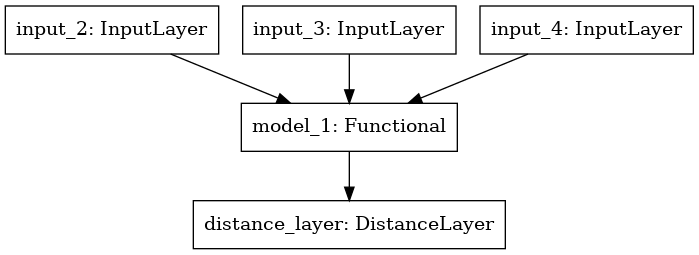

In [14]:
tf.keras.utils.plot_model(siamese_model)

In [15]:
import itertools

In [16]:
NUM_POS = 2
NUM_NEG = 4

In [67]:
def create_triplets(label_set):
    triplet_images = []
    triplets_set = []
    for label in set(label_set):
        label_pos_ids = np.where(label_set == label)[0]
        label_neg_ids = np.where(label_set != label)[0]
        np.random.shuffle(label_pos_ids)
        np.random.shuffle(label_neg_ids)
        
        positive_examples = label_pos_ids[:NUM_POS]
        negative_examples = label_neg_ids[:NUM_NEG]
        triplet_labels = list(itertools.product(positive_examples, positive_examples, negative_examples))
        for trp in triplet_labels:
            triplet_images.append([x_train[trp[0]], x_train[trp[1]], x_train[trp[2]]])
    return triplet_images, np.array([1] * len(triplet_images))

In [68]:
triplets, labels  = create_triplets(y_train)

In [70]:
np.array(triplets).shape, labels.shape, 

((160, 3, 28, 28, 1), (160,))

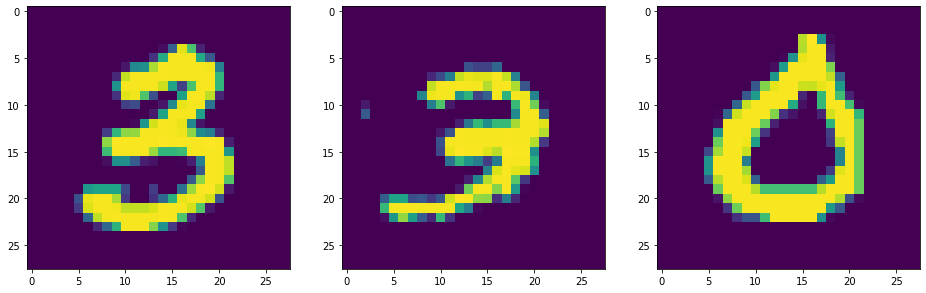

In [71]:
import matplotlib.pyplot as plt
num = 58
plt.figure(figsize= (16,5))
plt.subplot(1,3,1)
plt.imshow(triplets[num][0])
plt.subplot(1,3,2)
plt.imshow(triplets[num][1])
plt.subplot(1,3,3)
plt.imshow(triplets[num][2])

In [72]:
def accuracy(y_true, y_pred):
    """
    returns the keras binary accuracy
    """
    return binary_accuracy(y_true, 1 - y_pred)

In [73]:
np.array(triplets).shape

(160, 3, 28, 28, 1)

In [75]:
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), metrics=accuracy)

In [76]:
siamese_model.fit(triplets, labels, epochs = 2)

ValueError: Data cardinality is ambiguous:
  x sizes: 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28
  y sizes: 160
Make sure all arrays contain the same number of samples.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f9d7a30a-760e-4df9-995d-bfc22963224f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>